# Regression MPE

Here we try to create regressions to predict MPE on the basis of other features.
This code creates Table 1,2,3,5 in the paper

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import folium
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [2]:
regioni_cols = ['ABRUZZO', 'LAZIO', 'MARCHE', 'UMBRIA']

In [3]:
variaz = pd.read_csv('quake_data/variaz_phone_all.csv', sep=',')
variaz

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz,Variaz_init,Variaz_end
0,Abbateggio,0.0,490.128191,528.004679,0.077279,-14.463816,0.705066,-19.227151
1,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257
3,Acquacanina,1.0,661.076764,515.862884,-0.219663,-34.800125,-9.641580,-42.700415
4,Acqualagna,0.0,6232.440927,6788.446451,0.089212,-9.518700,-9.400079,-9.555950
...,...,...,...,...,...,...,...,...
658,Villa Santa Lucia degli Abruzzi,0.0,619.704165,615.334550,-0.007051,-10.220925,-5.554247,-11.686356
659,Villamagna,0.0,2299.570141,2671.182335,0.161601,-4.337274,1.206108,-6.078008
660,Visso,1.0,3745.319302,2389.214715,-0.362080,-39.942473,-18.534044,-46.665151
661,Viterbo,0.0,59906.488893,70060.167213,0.169492,7.167185,2.410811,8.660783


In [4]:
distance = pd.read_csv('quake_data/distance_from_epicenter.csv', sep=',')
variaz = variaz.merge(distance)
variaz.head()

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz,Variaz_init,Variaz_end,Distance_from_epicenter
0,Abbateggio,0.0,490.128191,528.004679,0.077279,-14.463816,0.705066,-19.227151,84.008154
1,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677,67.559108
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000
3,Acquacanina,1.0,661.076764,515.862884,-0.219663,-34.800125,-9.641580,-42.700415,14.633192
4,Acqualagna,0.0,6232.440927,6788.446451,0.089212,-9.518700,-9.400079,-9.555950,94.928297


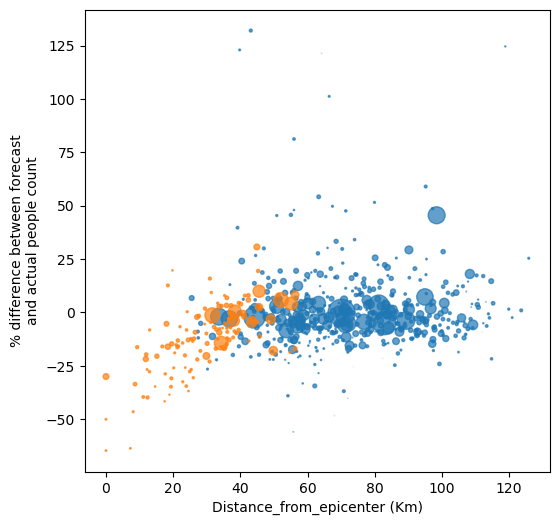

In [5]:
crat0 = variaz[variaz['Cratere Centro Italia 2016']==0]
crat1 = variaz[variaz['Cratere Centro Italia 2016']==1]
crat1 = crat1[crat1['Comune']!='Sellano']
plt.figure(figsize = (6,6))
plt.scatter(crat0['Distance_from_epicenter'],crat0['Variaz'],s=crat0['media_dopo'] / 500,alpha=0.7)
plt.scatter(crat1['Distance_from_epicenter'],crat1['Variaz'],s=crat1['media_dopo'] / 500,alpha=0.7)
plt.xlabel('Distance_from_epicenter (Km)')
plt.ylabel('% difference between forecast\nand actual people count',multialignment='center')
plt.savefig('images/distance_desnt_explain.pdf',bbox_inches='tight')  
plt.show()

In [6]:
#industries = pd.read_csv('quake_data/imprese_ateco_wide_norm_by_pop.csv', sep=',')
#ateco_names = list(industries.columns)[1:]
#industries['INDUSTRIES']=industries.loc[:,ateco_names].sum(axis='columns')
#industries = industries[['Comune','INDUSTRIES']]
#industries

Distance from epicenter alone cannot explain Variaz


In [7]:
imprese_ateco_wide = pd.read_csv('quake_data/imprese_ateco_wide.csv', sep=',')
#imprese_ateco_wide = pd.read_csv('quake_data/imprese_ateco_wide_norm_by_pop.csv', sep=',')
imprese_ateco_wide.head(2)

,Comune,AGRICOLTURE,OTHER SERV,PUBLIC ADMIN,REAL ESTATE,ENTERTAINMENT,HOSPITALITY,FINANCE,MANUFACTURING,TECH SERVICES,...,CONSTRUCTIONS,MINING,WASTE MGMT,UTILITIES,EDUCATION,BUSINESS SUPPORT SERVICES,EXTRA,HEALTHCARE,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
0,Abbateggio,0.0,0.0,0.0,0.0,0.0,0.24878,0.0,0.0,0.0,...,0.75122,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Acciano,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.228916,0.0,0.0,0.0,0.0


In [8]:
ateco_names = list(imprese_ateco_wide.columns)[1:]
ateco_names

['AGRICOLTURE',
 'OTHER SERV',
 'PUBLIC ADMIN',
 'REAL ESTATE',
 'ENTERTAINMENT',
 'HOSPITALITY',
 'FINANCE',
 'MANUFACTURING',
 'TECH SERVICES',
 'WHOLE/RETAIL SALES',
 'CONSTRUCTIONS',
 'MINING',
 'WASTE MGMT',
 'UTILITIES',
 'EDUCATION',
 'BUSINESS SUPPORT SERVICES',
 'EXTRA',
 'HEALTHCARE',
 'COMMUNICATION AND INFORMATION SERV.',
 'LOGISTICS']

In [9]:
#imprese_ateco_wide = imprese_ateco_wide.merge(industries)
#imprese_ateco_wide

In [10]:
#urb = pd.read_csv('quake_data/Classificazioni statistiche-e-dimensione-dei-comuni_2016.csv',sep=';')
#urb = urb[['Denominazione (italiana e straniera)','Grado di urbanizzazione']]
#urb.columns = ['Comune','URBANIZATION']
#urb

In [11]:
xy = pd.merge(variaz, imprese_ateco_wide, how='inner', on='Comune').fillna(0)
#xy = pd.merge(xy,urb, how='left', on='Comune').fillna(0)
#xy['Distance_from_epicenter']=(xy['Distance_from_epicenter']-xy['Distance_from_epicenter'].mean())/xy['Distance_from_epicenter'].std()

xy.columns = ['Comune', 'CRATER', 'PHONE_BEFORE', 'PHONE_AFTER',
              'PCGH', 'MPE', 'MPE_INIT','MPE_END','DISTANCE FROM EPICENTER']+ateco_names#+['INDUSTRIES','URBANIZATION']

xy[xy['CRATER']==1]

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,MPE_INIT,MPE_END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,CONSTRUCTIONS,MINING,WASTE MGMT,UTILITIES,EDUCATION,BUSINESS SUPPORT SERVICES,EXTRA,HEALTHCARE,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.174078
5,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.131887,0.069939,0.0,0.000000,0.000000,0.003501,0.0,0.001065,0.000000,0.035921
14,Amandola,1.0,6960.993251,7448.921338,0.070095,-16.146012,-2.843389,-20.323303,18.427903,0.006760,...,0.024106,0.000000,0.0,0.000000,0.000579,0.051688,0.0,0.000000,0.042069,0.000000
15,Amatrice,1.0,5160.892538,3156.834968,-0.388316,-33.683988,-16.591377,-39.051413,8.649987,0.019120,...,0.228585,0.000000,0.0,0.000000,0.000000,0.002177,0.0,0.000000,0.000000,0.000000
19,Antrodoco,1.0,2939.074875,3078.275723,0.047362,2.916035,2.454171,3.061070,34.367157,0.000000,...,0.488605,0.000000,0.0,0.000000,0.000000,0.027920,0.0,0.002386,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,Ussita,1.0,1872.041130,627.407278,-0.664854,-63.773951,-31.169307,-74.012467,7.256875,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
552,Valle Castellana,1.0,3014.909998,2811.514252,-0.067463,-13.247536,-7.710898,-14.986153,21.399092,0.183723,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000975,0.000000
554,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.230511,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
558,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011706,...,0.558528,0.000000,0.0,0.011467,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [12]:
def add_regioni(df):
    cod_reg_nome = pd.DataFrame({'COD_REG':[10,11,12,13],'Regione':['UMBRIA','MARCHE','LAZIO','ABRUZZO']})
    comune_regione = pd.read_csv('quake_data/comune_regione.csv').merge(cod_reg_nome)[['Comune','Regione']]
    df = df.merge(comune_regione)
    regioni = pd.get_dummies(df['Regione']) #one hot encoding
    df = pd.concat([df,regioni],axis='columns').drop(['Regione'],axis='columns')
    return df

xy = add_regioni(xy)

In [13]:
alt = pd.read_csv('quake_data/Elab_Altimetrie_DEM.csv',sep=';')
alt = alt.loc[alt['COD_REG'].isin([10,11,12,13]),['NOME','ALT_MIN','MEDIA','MEDIANA']]
alt.columns = ['Comune','ALT_MIN','ALT_MEAN','ALT_MED']
xy = xy.merge(alt)

In [14]:
#near = pd.read_csv('quake_data/distance_from_big.csv')
#near.columns = ['Comune','DIST_FROM_BIG']
#xy = xy.merge(near)
#xy['DIST_FROM_BIG'] = xy['DIST_FROM_BIG'] / max(xy['DIST_FROM_BIG'])
#xy_crat = xy_crat.merge(near)
#xy_crat['DIST_FROM_BIG'] = xy_crat['DIST_FROM_BIG'] / max(xy_crat['DIST_FROM_BIG'])
#print(xy.shape)
#print(xy_crat.shape)
xy[xy['CRATER']==1]

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,MPE_INIT,MPE_END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,HEALTHCARE,COMMUNICATION AND INFORMATION SERV.,LOGISTICS,ABRUZZO,LAZIO,MARCHE,UMBRIA,ALT_MIN,ALT_MEAN,ALT_MED
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,0.000000,0.000000,0.174078,0,1,0,0,670,1181.8030,1125
5,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.001065,0.000000,0.035921,0,0,1,0,242,860.2225,825
14,Amandola,1.0,6960.993251,7448.921338,0.070095,-16.146012,-2.843389,-20.323303,18.427903,0.006760,...,0.000000,0.042069,0.000000,0,0,1,0,305,604.1498,543
15,Amatrice,1.0,5160.892538,3156.834968,-0.388316,-33.683988,-16.591377,-39.051413,8.649987,0.019120,...,0.000000,0.000000,0.000000,0,1,0,0,749,1255.9070,1125
19,Antrodoco,1.0,2939.074875,3078.275723,0.047362,2.916035,2.454171,3.061070,34.367157,0.000000,...,0.002386,0.000000,0.000000,0,1,0,0,474,1166.0700,1158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,Ussita,1.0,1872.041130,627.407278,-0.664854,-63.773951,-31.169307,-74.012467,7.256875,0.000000,...,0.000000,0.000000,0.000000,0,0,1,0,669,1323.2890,1238
550,Valle Castellana,1.0,3014.909998,2811.514252,-0.067463,-13.247536,-7.710898,-14.986153,21.399092,0.183723,...,0.000000,0.000975,0.000000,1,0,0,0,315,1091.3370,1015
552,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.000000,0.000000,0.000000,0,0,0,1,299,781.4977,785
556,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011706,...,0.000000,0.000000,0.000000,0,0,1,0,176,432.6170,419


In [15]:
xy.to_csv('quake_data/X_regression.csv',index=False)

# Add Damage/Reconstruction DATA SISMA

In [16]:
sisma = pd.read_csv('quake_data/sisma_all.csv')

In [17]:
x_regression = pd.read_csv('quake_data/X_regression.csv')

ateco_names = ['AGRICOLTURE','REAL ESTATE','HOSPITALITY','MANUFACTURING','TECH SERVICES','WHOLE/RETAIL SALES','CONSTRUCTIONS','BUSINESS SUPPORT SERVICES','COMMUNICATION AND INFORMATION SERV.','LOGISTICS','HEALTHCARE','FINANCE','UTILITIES']
#ateco_names += ['PUBLIC ADMIN', 'ENTERTAINMENT','MINING', 'WASTE MGMT','EXTRA', 'EDUCATION','OTHER SERV']


x_regression = x_regression[x_regression['CRATER']==1]
x_regression = x_regression.loc[x_regression['Comune']!='Sellano',:] #remove outlier
x_regression

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,MPE_INIT,MPE_END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,HEALTHCARE,COMMUNICATION AND INFORMATION SERV.,LOGISTICS,ABRUZZO,LAZIO,MARCHE,UMBRIA,ALT_MIN,ALT_MEAN,ALT_MED
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,0.000000,0.000000,0.174078,0,1,0,0,670,1181.8030,1125
5,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.001065,0.000000,0.035921,0,0,1,0,242,860.2225,825
14,Amandola,1.0,6960.993251,7448.921338,0.070095,-16.146012,-2.843389,-20.323303,18.427903,0.006760,...,0.000000,0.042069,0.000000,0,0,1,0,305,604.1498,543
15,Amatrice,1.0,5160.892538,3156.834968,-0.388316,-33.683988,-16.591377,-39.051413,8.649987,0.019120,...,0.000000,0.000000,0.000000,0,1,0,0,749,1255.9070,1125
19,Antrodoco,1.0,2939.074875,3078.275723,0.047362,2.916035,2.454171,3.061070,34.367157,0.000000,...,0.002386,0.000000,0.000000,0,1,0,0,474,1166.0700,1158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,Ussita,1.0,1872.041130,627.407278,-0.664854,-63.773951,-31.169307,-74.012467,7.256875,0.000000,...,0.000000,0.000000,0.000000,0,0,1,0,669,1323.2890,1238
550,Valle Castellana,1.0,3014.909998,2811.514252,-0.067463,-13.247536,-7.710898,-14.986153,21.399092,0.183723,...,0.000000,0.000975,0.000000,1,0,0,0,315,1091.3370,1015
552,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.000000,0.000000,0.000000,0,0,0,1,299,781.4977,785
556,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011706,...,0.000000,0.000000,0.000000,0,0,1,0,176,432.6170,419


In [18]:
xy = x_regression.merge(sisma, how='inner')
xy.rename(columns = {'N_Interventi_priv':'RCR PRIV', 'N_Interventi_pubb':'RCR PUB'}, inplace = True)
for c in xy.columns:
    xy.rename(columns = {c:c.replace('_',' ')}, inplace = True)
xy['Eur Interventi priv'] = xy['Eur Interventi priv'] / 1000
xy['Eur Interventi pubb'] = xy['Eur Interventi pubb'] / 1000
xy.rename(columns = {'Eur Interventi priv':'RCR PRIV (K EUR)', 'Eur Interventi pubb':'RCR PUB (K EUR)'}, inplace = True)
print(xy.columns)
xy

Index(['Comune', 'CRATER', 'PHONE BEFORE', 'PHONE AFTER', 'PCGH', 'MPE',
       'MPE INIT', 'MPE END', 'DISTANCE FROM EPICENTER', 'AGRICOLTURE',
       'OTHER SERV', 'PUBLIC ADMIN', 'REAL ESTATE', 'ENTERTAINMENT',
       'HOSPITALITY', 'FINANCE', 'MANUFACTURING', 'TECH SERVICES',
       'WHOLE/RETAIL SALES', 'CONSTRUCTIONS', 'MINING', 'WASTE MGMT',
       'UTILITIES', 'EDUCATION', 'BUSINESS SUPPORT SERVICES', 'EXTRA',
       'HEALTHCARE', 'COMMUNICATION AND INFORMATION SERV.', 'LOGISTICS',
       'ABRUZZO', 'LAZIO', 'MARCHE', 'UMBRIA', 'ALT MIN', 'ALT MEAN',
       'ALT MED', 'RCR FORECAST', 'RCR ACTUAL', 'OOPP', 'SMALL DAMAGE REQ.',
       'GREAT DAMAGE REQ.', 'TOT REQ.', 'ACCEPTED REQ.', 'BUILDING STARTED',
       'BUILIDING CONCLUDED', 'SMALL DAMAGE', 'GREAT DAMAGE', 'TOT. DAMAGE',
       'N Interventi', 'Eur Interventi', 'RCR PRIV', 'RCR PRIV (K EUR)',
       'RCR PUB', 'RCR PUB (K EUR)', 'pop iniz 2016', 'DELTA FORECAST ACTUAL',
       'DELTA G DAMAGE Interventi', 'P RCR'],
      

,Comune,CRATER,PHONE BEFORE,PHONE AFTER,PCGH,MPE,MPE INIT,MPE END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,N Interventi,Eur Interventi,RCR PRIV,RCR PRIV (K EUR),RCR PUB,RCR PUB (K EUR),pop iniz 2016,DELTA FORECAST ACTUAL,DELTA G DAMAGE Interventi,P RCR
0,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,1.249617,6.901996e+05,0.220521,98.190332,0.087289,87.566840,653,2.355283,-1.150077,0.041745
1,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.344590,1.411088e+05,0.139344,54.703533,0.004590,3.828241,3050,0.335738,-0.303934,0.209266
2,Amandola,1.0,6960.993251,7448.921338,0.070095,-16.146012,-2.843389,-20.323303,18.427903,0.006760,...,0.178215,7.727372e+04,0.061472,20.038571,0.004044,6.301821,3709,0.219197,-0.163926,0.131410
3,Amatrice,1.0,5160.892538,3156.834968,-0.388316,-33.683988,-16.591377,-39.051413,8.649987,0.019120,...,0.899849,5.122456e+05,0.319728,156.100280,0.036281,56.877203,2646,1.473545,-0.761905,0.100162
4,Antrodoco,1.0,2939.074875,3078.275723,0.047362,2.916035,2.454171,3.061070,34.367157,0.000000,...,0.075444,2.507194e+04,0.046598,8.968152,0.004438,2.567574,2704,0.071746,-0.072855,0.230159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Ussita,1.0,1872.041130,627.407278,-0.664854,-63.773951,-31.169307,-74.012467,7.256875,0.000000,...,1.590476,1.348795e+06,0.392857,398.466628,0.080952,146.366139,420,2.052381,-1.440476,0.083953
119,Valle Castellana,1.0,3014.909998,2811.514252,-0.067463,-13.247536,-7.710898,-14.986153,21.399092,0.183723,...,0.316812,9.612084e+04,0.123421,14.526085,0.007775,2.660439,1029,0.527697,-0.304179,0.076531
120,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.172070,3.196431e+04,0.037406,6.174075,0.029925,6.500602,401,0.169576,-0.167082,0.081081
121,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011706,...,0.089469,3.391978e+04,0.041007,11.629947,0.002796,4.346910,2146,0.084809,-0.075489,0.222222


In [19]:
def run_regression(feat, ts=['MPE INIT','MPE END','MPE'], img_file=False, tex_file='regression.tex', xy=xy):
    x = xy.loc[:,feat]
    x = sm.add_constant(x)
    models = []
    for i in range(len(ts)):
        t = ts[i]
        y = xy.loc[:,t] 
        model = sm.OLS(y, x).fit()
        models.append(model)
        
    
    if img_file != False:
        plt.figure(figsize = (20,6))
        for i in range(len(models)):
            yp = models[i].predict(x)
            plt.subplot(1,len(ts),i+1)
            for r in regioni_cols:
                x_ = xy.loc[xy[r]==1,:]
                plt.scatter(y[x_.index],yp[x_.index],alpha=0.7,label=r)
            plt.xlabel(t)
            plt.ylabel('PREDICTED '+t)
            plt.legend(loc='lower right')
        plt.savefig('images/'+img_file,bbox_inches='tight')  
        plt.show()

    stargazer = Stargazer(models)
    stargazer.custom_columns(ts,[1]*len(ts))
    stargazer.covariate_order(feat)
    stargazer.show_model_numbers(False)
    stargazer.show_degrees_of_freedom(False)
    with open('models/'+tex_file,'w') as f:
        f.write(stargazer.render_latex())
    return stargazer



xy.columns

geo_f = ['DISTANCE FROM EPICENTER','ALT MED']
ateco_f = ateco_names
sisma_f = ['RCR PRIV','RCR PUB']
#sisma_f = ['RCR PRIV (K EUR)','RCR PUB (K EUR)']
#sisma_f = ['RCR FORECAST']



In [20]:
run_regression(geo_f+sisma_f,tex_file='geo-sisma.tex')


In [21]:
run_regression(geo_f+ateco_f,tex_file='geo-ateco.tex')

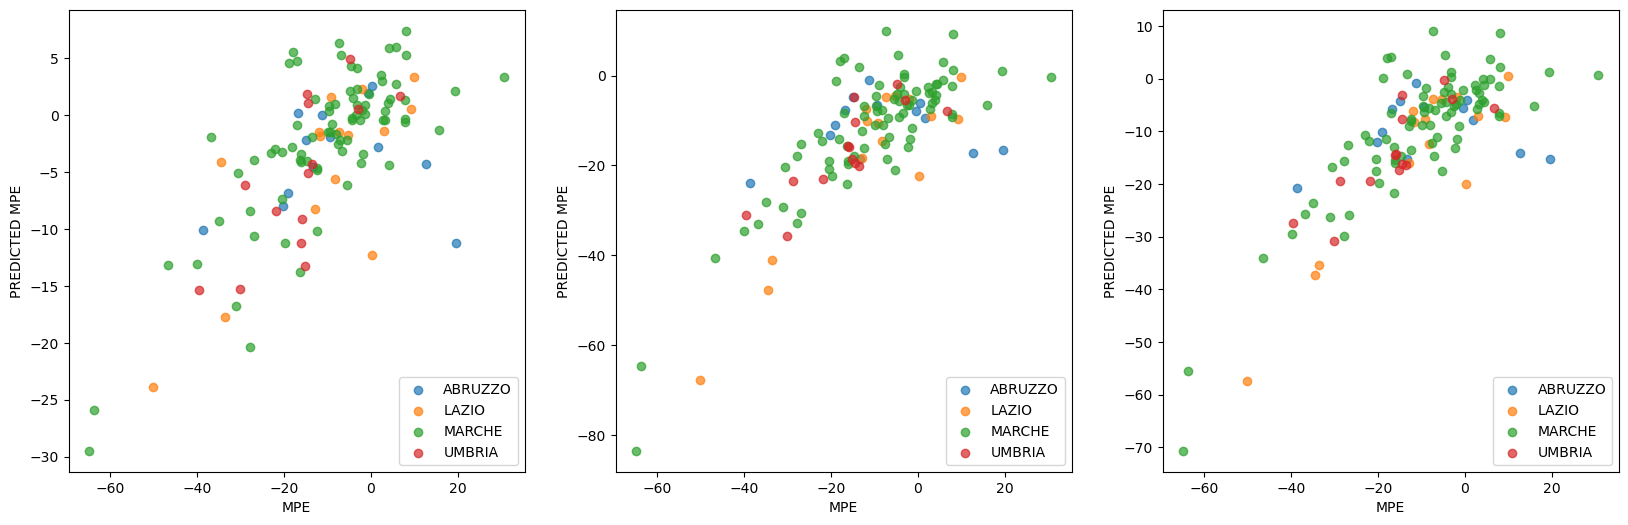

In [22]:
run_regression(geo_f+sisma_f+ateco_f,img_file='geo-sisma-ateco.pdf',tex_file='geo-sisma-ateco.tex')

# Extra Analysis for Supplementary

In [23]:
for r in regioni_cols:
    run_regression(geo_f+sisma_f,tex_file='geo-sisma-'+r+'.tex',xy=xy.loc[xy[r]==1])


In [24]:
sisma_f = ['RCR FORECAST']
run_regression(geo_f+sisma_f,tex_file='geo-sismaf.tex')

In [25]:
sisma_f = ['RCR PRIV','RCR PUB']
run_regression(geo_f+sisma_f,tex_file='geo-sisman.tex')